# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 13.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 14.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 4.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [1]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [3]:
client = MongoClient(mongod_connect)
db = client.gp1 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [4]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [5]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [6]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Jan 14 16:44:50 +0000 2021'
'Thu Jan 14 16:44:47 +0000 2021'
'Thu Jan 14 16:44:42 +0000 2021'
'Thu Jan 14 16:44:26 +0000 2021'
'Thu Jan 14 16:44:16 +0000 2021'
'Thu Jan 14 16:44:14 +0000 2021'
'Thu Jan 14 16:44:11 +0000 2021'
'Thu Jan 14 16:44:09 +0000 2021'
'Thu Jan 14 16:44:06 +0000 2021'
'Thu Jan 14 16:44:02 +0000 2021'
'Thu Jan 14 16:44:01 +0000 2021'
'Thu Jan 14 16:43:58 +0000 2021'
'Thu Jan 14 16:43:57 +0000 2021'
'Thu Jan 14 16:43:56 +0000 2021'
'Thu Jan 14 16:43:48 +0000 2021'
'Thu Jan 14 16:43:38 +0000 2021'
'Thu Jan 14 16:43:33 +0000 2021'
'Thu Jan 14 16:43:32 +0000 2021'
'Thu Jan 14 16:43:26 +0000 2021'
'Thu Jan 14 16:43:24 +0000 2021'
'Thu Jan 14 16:43:23 +0000 2021'
'Thu Jan 14 16:43:22 +0000 2021'
'Thu Jan 14 16:43:19 +0000 2021'
'Thu Jan 14 16:43:17 +0000 2021'
'Thu Jan 14 16:43:10 +0000 2021'
'Thu Jan 14 16:43:06 +0000 2021'
'Thu Jan 14 16:43:00 +0000 2021'
'Thu Jan 14 16:42:56 +0000 2021'
'Thu Jan 14 16:42:56 +0000 2021'
'Thu Jan 14 16:42:56 +0000 2021'
'Thu Jan 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [7]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Jan 14 16:37:07 +0000 2021'
'Thu Jan 14 16:37:06 +0000 2021'
'Thu Jan 14 16:37:05 +0000 2021'
'Thu Jan 14 16:37:02 +0000 2021'
'Thu Jan 14 16:37:01 +0000 2021'
'Thu Jan 14 16:36:59 +0000 2021'
'Thu Jan 14 16:36:58 +0000 2021'
'Thu Jan 14 16:36:55 +0000 2021'
'Thu Jan 14 16:36:55 +0000 2021'
'Thu Jan 14 16:36:48 +0000 2021'
'Thu Jan 14 16:36:46 +0000 2021'
'Thu Jan 14 16:36:46 +0000 2021'
'Thu Jan 14 16:36:44 +0000 2021'
'Thu Jan 14 16:36:39 +0000 2021'
'Thu Jan 14 16:36:36 +0000 2021'
'Thu Jan 14 16:36:23 +0000 2021'
'Thu Jan 14 16:36:17 +0000 2021'
'Thu Jan 14 16:36:14 +0000 2021'
'Thu Jan 14 16:36:13 +0000 2021'
'Thu Jan 14 16:35:56 +0000 2021'
'Thu Jan 14 16:35:40 +0000 2021'
'Thu Jan 14 16:35:38 +0000 2021'
'Thu Jan 14 16:35:38 +0000 2021'
'Thu Jan 14 16:35:37 +0000 2021'
'Thu Jan 14 16:35:36 +0000 2021'
'Thu Jan 14 16:35:35 +0000 2021'
'Thu Jan 14 16:35:29 +0000 2021'
'Thu Jan 14 16:35:27 +0000 2021'
'Thu Jan 14 16:35:24 +0000 2021'
'Thu Jan 14 16:35:22 +0000 2021'
'Thu Jan 1

'Thu Jan 14 16:13:33 +0000 2021'
'Thu Jan 14 16:13:24 +0000 2021'
'Thu Jan 14 16:13:09 +0000 2021'
'Thu Jan 14 16:13:03 +0000 2021'
'Thu Jan 14 16:13:01 +0000 2021'
'Thu Jan 14 16:12:56 +0000 2021'
'Thu Jan 14 16:12:25 +0000 2021'
'Thu Jan 14 16:12:19 +0000 2021'
'Thu Jan 14 16:11:54 +0000 2021'
'Thu Jan 14 16:11:46 +0000 2021'
'Thu Jan 14 16:11:28 +0000 2021'
'Thu Jan 14 16:11:12 +0000 2021'
'Thu Jan 14 16:11:06 +0000 2021'
'Thu Jan 14 16:10:59 +0000 2021'
'Thu Jan 14 16:10:59 +0000 2021'
'Thu Jan 14 16:10:54 +0000 2021'
'Thu Jan 14 16:10:51 +0000 2021'
'Thu Jan 14 16:10:48 +0000 2021'
'Thu Jan 14 16:10:47 +0000 2021'
'Thu Jan 14 16:10:30 +0000 2021'
'Thu Jan 14 16:10:17 +0000 2021'
'Thu Jan 14 16:10:13 +0000 2021'
'Thu Jan 14 16:10:12 +0000 2021'
'Thu Jan 14 16:10:11 +0000 2021'
'Thu Jan 14 16:09:51 +0000 2021'
'Thu Jan 14 16:09:50 +0000 2021'
'Thu Jan 14 16:09:43 +0000 2021'
'Thu Jan 14 16:09:36 +0000 2021'
'Thu Jan 14 16:09:26 +0000 2021'
'Thu Jan 14 16:09:13 +0000 2021'
'Thu Jan 1

'Thu Jan 14 15:39:07 +0000 2021'
'Thu Jan 14 15:39:05 +0000 2021'
'Thu Jan 14 15:38:40 +0000 2021'
'Thu Jan 14 15:38:40 +0000 2021'
'Thu Jan 14 15:38:36 +0000 2021'
'Thu Jan 14 15:38:32 +0000 2021'
'Thu Jan 14 15:38:08 +0000 2021'
'Thu Jan 14 15:38:06 +0000 2021'
'Thu Jan 14 15:37:40 +0000 2021'
'Thu Jan 14 15:37:33 +0000 2021'
'Thu Jan 14 15:37:28 +0000 2021'
'Thu Jan 14 15:37:14 +0000 2021'
'Thu Jan 14 15:37:04 +0000 2021'
'Thu Jan 14 15:36:38 +0000 2021'
'Thu Jan 14 15:36:36 +0000 2021'
'Thu Jan 14 15:36:35 +0000 2021'
'Thu Jan 14 15:36:33 +0000 2021'
'Thu Jan 14 15:36:20 +0000 2021'
'Thu Jan 14 15:36:19 +0000 2021'
'Thu Jan 14 15:36:18 +0000 2021'
'Thu Jan 14 15:36:15 +0000 2021'
'Thu Jan 14 15:36:12 +0000 2021'
'Thu Jan 14 15:36:03 +0000 2021'
'Thu Jan 14 15:36:02 +0000 2021'
'Thu Jan 14 15:36:01 +0000 2021'
'Thu Jan 14 15:35:37 +0000 2021'
'Thu Jan 14 15:35:34 +0000 2021'
'Thu Jan 14 15:35:29 +0000 2021'
'Thu Jan 14 15:35:25 +0000 2021'
'Thu Jan 14 15:35:21 +0000 2021'
'Thu Jan 1

'Thu Jan 14 15:13:06 +0000 2021'
'Thu Jan 14 15:13:03 +0000 2021'
'Thu Jan 14 15:13:01 +0000 2021'
'Thu Jan 14 15:12:52 +0000 2021'
'Thu Jan 14 15:12:28 +0000 2021'
'Thu Jan 14 15:12:22 +0000 2021'
'Thu Jan 14 15:12:09 +0000 2021'
'Thu Jan 14 15:11:59 +0000 2021'
'Thu Jan 14 15:11:54 +0000 2021'
'Thu Jan 14 15:11:44 +0000 2021'
'Thu Jan 14 15:11:43 +0000 2021'
'Thu Jan 14 15:11:41 +0000 2021'
'Thu Jan 14 15:11:33 +0000 2021'
'Thu Jan 14 15:11:21 +0000 2021'
'Thu Jan 14 15:11:07 +0000 2021'
'Thu Jan 14 15:11:03 +0000 2021'
'Thu Jan 14 15:10:48 +0000 2021'
'Thu Jan 14 15:10:44 +0000 2021'
'Thu Jan 14 15:10:20 +0000 2021'
'Thu Jan 14 15:09:59 +0000 2021'
'Thu Jan 14 15:09:59 +0000 2021'
'Thu Jan 14 15:09:59 +0000 2021'
'Thu Jan 14 15:09:49 +0000 2021'
'Thu Jan 14 15:09:47 +0000 2021'
'Thu Jan 14 15:09:42 +0000 2021'
'Thu Jan 14 15:09:28 +0000 2021'
'Thu Jan 14 15:09:26 +0000 2021'
'Thu Jan 14 15:09:26 +0000 2021'
'Thu Jan 14 15:09:26 +0000 2021'
'Thu Jan 14 15:09:26 +0000 2021'
'Thu Jan 1

'Thu Jan 14 14:33:05 +0000 2021'
'Thu Jan 14 14:33:02 +0000 2021'
'Thu Jan 14 14:33:00 +0000 2021'
'Thu Jan 14 14:32:46 +0000 2021'
'Thu Jan 14 14:32:24 +0000 2021'
'Thu Jan 14 14:32:19 +0000 2021'
'Thu Jan 14 14:31:57 +0000 2021'
'Thu Jan 14 14:31:50 +0000 2021'
'Thu Jan 14 14:31:46 +0000 2021'
'Thu Jan 14 14:31:45 +0000 2021'
'Thu Jan 14 14:31:32 +0000 2021'
'Thu Jan 14 14:31:23 +0000 2021'
'Thu Jan 14 14:31:14 +0000 2021'
'Thu Jan 14 14:31:14 +0000 2021'
'Thu Jan 14 14:31:02 +0000 2021'
'Thu Jan 14 14:30:50 +0000 2021'
'Thu Jan 14 14:30:37 +0000 2021'
'Thu Jan 14 14:30:31 +0000 2021'
'Thu Jan 14 14:30:30 +0000 2021'
'Thu Jan 14 14:30:29 +0000 2021'
'Thu Jan 14 14:30:27 +0000 2021'
'Thu Jan 14 14:30:22 +0000 2021'
'Thu Jan 14 14:30:22 +0000 2021'
'Thu Jan 14 14:30:20 +0000 2021'
'Thu Jan 14 14:30:18 +0000 2021'
'Thu Jan 14 14:30:15 +0000 2021'
'Thu Jan 14 14:30:12 +0000 2021'
'Thu Jan 14 14:30:12 +0000 2021'
'Thu Jan 14 14:30:08 +0000 2021'
'Thu Jan 14 14:30:06 +0000 2021'
'Thu Jan 1

'Thu Jan 14 14:04:20 +0000 2021'
'Thu Jan 14 14:04:01 +0000 2021'
'Thu Jan 14 14:04:01 +0000 2021'
'Thu Jan 14 14:03:32 +0000 2021'
'Thu Jan 14 14:03:22 +0000 2021'
'Thu Jan 14 14:03:08 +0000 2021'
'Thu Jan 14 14:03:06 +0000 2021'
'Thu Jan 14 14:03:01 +0000 2021'
'Thu Jan 14 14:02:53 +0000 2021'
'Thu Jan 14 14:02:50 +0000 2021'
'Thu Jan 14 14:02:47 +0000 2021'
'Thu Jan 14 14:02:47 +0000 2021'
'Thu Jan 14 14:02:33 +0000 2021'
'Thu Jan 14 14:02:26 +0000 2021'
'Thu Jan 14 14:02:25 +0000 2021'
'Thu Jan 14 14:02:22 +0000 2021'
'Thu Jan 14 14:02:15 +0000 2021'
'Thu Jan 14 14:02:11 +0000 2021'
'Thu Jan 14 14:02:10 +0000 2021'
'Thu Jan 14 14:02:08 +0000 2021'
'Thu Jan 14 14:02:08 +0000 2021'
'Thu Jan 14 14:02:06 +0000 2021'
'Thu Jan 14 14:02:05 +0000 2021'
'Thu Jan 14 14:01:59 +0000 2021'
'Thu Jan 14 14:01:44 +0000 2021'
'Thu Jan 14 14:01:43 +0000 2021'
'Thu Jan 14 14:01:41 +0000 2021'
'Thu Jan 14 14:01:38 +0000 2021'
'Thu Jan 14 14:01:38 +0000 2021'
'Thu Jan 14 14:01:35 +0000 2021'
'Thu Jan 1

'Thu Jan 14 13:15:22 +0000 2021'
'Thu Jan 14 13:15:17 +0000 2021'
'Thu Jan 14 13:15:07 +0000 2021'
'Thu Jan 14 13:15:02 +0000 2021'
'Thu Jan 14 13:14:27 +0000 2021'
'Thu Jan 14 13:14:27 +0000 2021'
'Thu Jan 14 13:14:24 +0000 2021'
'Thu Jan 14 13:14:06 +0000 2021'
'Thu Jan 14 13:13:38 +0000 2021'
'Thu Jan 14 13:13:27 +0000 2021'
'Thu Jan 14 13:13:11 +0000 2021'
'Thu Jan 14 13:12:59 +0000 2021'
'Thu Jan 14 13:12:26 +0000 2021'
'Thu Jan 14 13:12:19 +0000 2021'
'Thu Jan 14 13:12:01 +0000 2021'
'Thu Jan 14 13:11:53 +0000 2021'
'Thu Jan 14 13:11:32 +0000 2021'
'Thu Jan 14 13:11:03 +0000 2021'
'Thu Jan 14 13:10:47 +0000 2021'
'Thu Jan 14 13:10:34 +0000 2021'
'Thu Jan 14 13:10:09 +0000 2021'
'Thu Jan 14 13:09:57 +0000 2021'
'Thu Jan 14 13:09:12 +0000 2021'
'Thu Jan 14 13:08:34 +0000 2021'
'Thu Jan 14 13:07:59 +0000 2021'
'Thu Jan 14 13:07:26 +0000 2021'
'Thu Jan 14 13:06:46 +0000 2021'
'Thu Jan 14 13:05:47 +0000 2021'
'Thu Jan 14 13:05:19 +0000 2021'
'Thu Jan 14 13:05:04 +0000 2021'
'Thu Jan 1

'Thu Jan 14 11:39:52 +0000 2021'
'Thu Jan 14 11:37:33 +0000 2021'
'Thu Jan 14 11:37:30 +0000 2021'
'Thu Jan 14 11:36:54 +0000 2021'
'Thu Jan 14 11:36:50 +0000 2021'
'Thu Jan 14 11:36:42 +0000 2021'
'Thu Jan 14 11:36:33 +0000 2021'
'Thu Jan 14 11:36:28 +0000 2021'
'Thu Jan 14 11:36:26 +0000 2021'
'Thu Jan 14 11:36:12 +0000 2021'
'Thu Jan 14 11:36:04 +0000 2021'
'Thu Jan 14 11:34:32 +0000 2021'
'Thu Jan 14 11:34:28 +0000 2021'
'Thu Jan 14 11:34:20 +0000 2021'
'Thu Jan 14 11:34:06 +0000 2021'
'Thu Jan 14 11:34:05 +0000 2021'
'Thu Jan 14 11:33:44 +0000 2021'
'Thu Jan 14 11:32:42 +0000 2021'
'Thu Jan 14 11:32:11 +0000 2021'
'Thu Jan 14 11:29:02 +0000 2021'
'Thu Jan 14 11:28:32 +0000 2021'
'Thu Jan 14 11:26:49 +0000 2021'
'Thu Jan 14 11:26:12 +0000 2021'
'Thu Jan 14 11:24:56 +0000 2021'
'Thu Jan 14 11:19:57 +0000 2021'
'Thu Jan 14 11:19:23 +0000 2021'
'Thu Jan 14 11:19:21 +0000 2021'
'Thu Jan 14 11:16:15 +0000 2021'
'Thu Jan 14 11:15:55 +0000 2021'
'Thu Jan 14 11:14:47 +0000 2021'
'Thu Jan 1

'Thu Jan 14 07:31:59 +0000 2021'
'Thu Jan 14 07:30:12 +0000 2021'
'Thu Jan 14 07:29:43 +0000 2021'
'Thu Jan 14 07:28:27 +0000 2021'
'Thu Jan 14 07:26:52 +0000 2021'
'Thu Jan 14 07:26:41 +0000 2021'
'Thu Jan 14 07:26:17 +0000 2021'
'Thu Jan 14 07:24:31 +0000 2021'
'Thu Jan 14 07:20:49 +0000 2021'
'Thu Jan 14 07:19:36 +0000 2021'
'Thu Jan 14 07:19:24 +0000 2021'
'Thu Jan 14 07:17:36 +0000 2021'
'Thu Jan 14 07:15:08 +0000 2021'
'Thu Jan 14 07:14:53 +0000 2021'
'Thu Jan 14 07:13:48 +0000 2021'
'Thu Jan 14 07:13:48 +0000 2021'
'Thu Jan 14 07:11:00 +0000 2021'
'Thu Jan 14 07:10:29 +0000 2021'
'Thu Jan 14 07:10:28 +0000 2021'
'Thu Jan 14 07:09:55 +0000 2021'
'Thu Jan 14 07:09:46 +0000 2021'
'Thu Jan 14 07:09:43 +0000 2021'
'Thu Jan 14 07:09:34 +0000 2021'
'Thu Jan 14 07:09:03 +0000 2021'
'Thu Jan 14 07:05:39 +0000 2021'
'Thu Jan 14 07:05:02 +0000 2021'
'Thu Jan 14 07:04:21 +0000 2021'
'Thu Jan 14 07:03:02 +0000 2021'
'Thu Jan 14 07:00:11 +0000 2021'
'Thu Jan 14 06:58:59 +0000 2021'
'Thu Jan 1

'Thu Jan 14 04:51:02 +0000 2021'
'Thu Jan 14 04:51:00 +0000 2021'
'Thu Jan 14 04:50:59 +0000 2021'
'Thu Jan 14 04:50:57 +0000 2021'
'Thu Jan 14 04:50:15 +0000 2021'
'Thu Jan 14 04:50:13 +0000 2021'
'Thu Jan 14 04:50:10 +0000 2021'
'Thu Jan 14 04:50:04 +0000 2021'
'Thu Jan 14 04:50:02 +0000 2021'
'Thu Jan 14 04:49:53 +0000 2021'
'Thu Jan 14 04:49:43 +0000 2021'
'Thu Jan 14 04:49:41 +0000 2021'
'Thu Jan 14 04:49:35 +0000 2021'
'Thu Jan 14 04:49:22 +0000 2021'
'Thu Jan 14 04:49:22 +0000 2021'
'Thu Jan 14 04:49:12 +0000 2021'
'Thu Jan 14 04:48:56 +0000 2021'
'Thu Jan 14 04:48:54 +0000 2021'
'Thu Jan 14 04:48:54 +0000 2021'
'Thu Jan 14 04:48:52 +0000 2021'
'Thu Jan 14 04:48:43 +0000 2021'
'Thu Jan 14 04:48:35 +0000 2021'
'Thu Jan 14 04:48:18 +0000 2021'
'Thu Jan 14 04:48:15 +0000 2021'
'Thu Jan 14 04:48:12 +0000 2021'
'Thu Jan 14 04:48:00 +0000 2021'
'Thu Jan 14 04:47:42 +0000 2021'
'Thu Jan 14 04:47:40 +0000 2021'
'Thu Jan 14 04:47:38 +0000 2021'
'Thu Jan 14 04:46:04 +0000 2021'
'Thu Jan 1

'Thu Jan 14 02:50:58 +0000 2021'
'Thu Jan 14 02:50:55 +0000 2021'
'Thu Jan 14 02:50:47 +0000 2021'
'Thu Jan 14 02:48:48 +0000 2021'
'Thu Jan 14 02:48:18 +0000 2021'
'Thu Jan 14 02:48:04 +0000 2021'
'Thu Jan 14 02:47:57 +0000 2021'
'Thu Jan 14 02:47:48 +0000 2021'
'Thu Jan 14 02:47:19 +0000 2021'
'Thu Jan 14 02:46:49 +0000 2021'
'Thu Jan 14 02:46:27 +0000 2021'
'Thu Jan 14 02:43:26 +0000 2021'
'Thu Jan 14 02:43:13 +0000 2021'
'Thu Jan 14 02:43:12 +0000 2021'
'Thu Jan 14 02:41:41 +0000 2021'
'Thu Jan 14 02:41:29 +0000 2021'
'Thu Jan 14 02:40:51 +0000 2021'
'Thu Jan 14 02:39:10 +0000 2021'
'Thu Jan 14 02:39:01 +0000 2021'
'Thu Jan 14 02:37:42 +0000 2021'
'Thu Jan 14 02:37:33 +0000 2021'
'Thu Jan 14 02:37:05 +0000 2021'
'Thu Jan 14 02:36:39 +0000 2021'
'Thu Jan 14 02:36:32 +0000 2021'
'Thu Jan 14 02:36:25 +0000 2021'
'Thu Jan 14 02:36:18 +0000 2021'
'Thu Jan 14 02:36:08 +0000 2021'
'Thu Jan 14 02:36:02 +0000 2021'
'Thu Jan 14 02:35:38 +0000 2021'
'Thu Jan 14 02:35:34 +0000 2021'
'Thu Jan 1

'Thu Jan 14 01:14:17 +0000 2021'
'Thu Jan 14 01:13:58 +0000 2021'
'Thu Jan 14 01:13:53 +0000 2021'
'Thu Jan 14 01:13:23 +0000 2021'
'Thu Jan 14 01:12:54 +0000 2021'
'Thu Jan 14 01:12:41 +0000 2021'
'Thu Jan 14 01:12:23 +0000 2021'
'Thu Jan 14 01:12:11 +0000 2021'
'Thu Jan 14 01:11:33 +0000 2021'
'Thu Jan 14 01:11:25 +0000 2021'
'Thu Jan 14 01:11:23 +0000 2021'
'Thu Jan 14 01:11:11 +0000 2021'
'Thu Jan 14 01:11:08 +0000 2021'
'Thu Jan 14 01:11:03 +0000 2021'
'Thu Jan 14 01:10:44 +0000 2021'
'Thu Jan 14 01:10:38 +0000 2021'
'Thu Jan 14 01:10:20 +0000 2021'
'Thu Jan 14 01:09:29 +0000 2021'
'Thu Jan 14 01:09:17 +0000 2021'
'Thu Jan 14 01:08:38 +0000 2021'
'Thu Jan 14 01:08:14 +0000 2021'
'Thu Jan 14 01:08:13 +0000 2021'
'Thu Jan 14 01:07:50 +0000 2021'
'Thu Jan 14 01:07:47 +0000 2021'
'Thu Jan 14 01:07:20 +0000 2021'
'Thu Jan 14 01:07:04 +0000 2021'
'Thu Jan 14 01:07:01 +0000 2021'
'Thu Jan 14 01:06:54 +0000 2021'
'Thu Jan 14 01:06:52 +0000 2021'
'Thu Jan 14 01:06:23 +0000 2021'
'Thu Jan 1

'Thu Jan 14 00:05:45 +0000 2021'
'Thu Jan 14 00:05:43 +0000 2021'
'Thu Jan 14 00:05:31 +0000 2021'
'Thu Jan 14 00:04:55 +0000 2021'
'Thu Jan 14 00:04:54 +0000 2021'
'Thu Jan 14 00:04:28 +0000 2021'
'Thu Jan 14 00:04:10 +0000 2021'
'Thu Jan 14 00:04:09 +0000 2021'
'Thu Jan 14 00:03:36 +0000 2021'
'Thu Jan 14 00:03:23 +0000 2021'
'Thu Jan 14 00:03:23 +0000 2021'
'Thu Jan 14 00:03:19 +0000 2021'
'Thu Jan 14 00:02:58 +0000 2021'
'Thu Jan 14 00:02:45 +0000 2021'
'Thu Jan 14 00:02:42 +0000 2021'
'Thu Jan 14 00:02:30 +0000 2021'
'Thu Jan 14 00:02:14 +0000 2021'
'Thu Jan 14 00:01:49 +0000 2021'
'Thu Jan 14 00:01:28 +0000 2021'
'Thu Jan 14 00:01:05 +0000 2021'
'Thu Jan 14 00:00:54 +0000 2021'
'Thu Jan 14 00:00:46 +0000 2021'
'Thu Jan 14 00:00:11 +0000 2021'
'Wed Jan 13 23:59:58 +0000 2021'
'Wed Jan 13 23:59:13 +0000 2021'
'Wed Jan 13 23:58:57 +0000 2021'
'Wed Jan 13 23:58:48 +0000 2021'
'Wed Jan 13 23:58:38 +0000 2021'
'Wed Jan 13 23:58:25 +0000 2021'
'Wed Jan 13 23:58:03 +0000 2021'
'Wed Jan 1

'Wed Jan 13 23:23:13 +0000 2021'
'Wed Jan 13 23:23:09 +0000 2021'
'Wed Jan 13 23:22:47 +0000 2021'
'Wed Jan 13 23:22:39 +0000 2021'
'Wed Jan 13 23:22:29 +0000 2021'
'Wed Jan 13 23:22:28 +0000 2021'
'Wed Jan 13 23:22:25 +0000 2021'
'Wed Jan 13 23:22:08 +0000 2021'
'Wed Jan 13 23:21:55 +0000 2021'
'Wed Jan 13 23:21:39 +0000 2021'
'Wed Jan 13 23:21:36 +0000 2021'
'Wed Jan 13 23:21:12 +0000 2021'
'Wed Jan 13 23:21:07 +0000 2021'
'Wed Jan 13 23:21:05 +0000 2021'
'Wed Jan 13 23:21:03 +0000 2021'
'Wed Jan 13 23:21:00 +0000 2021'
'Wed Jan 13 23:20:50 +0000 2021'
'Wed Jan 13 23:20:44 +0000 2021'
'Wed Jan 13 23:20:44 +0000 2021'
'Wed Jan 13 23:20:34 +0000 2021'
'Wed Jan 13 23:20:20 +0000 2021'
'Wed Jan 13 23:20:16 +0000 2021'
'Wed Jan 13 23:20:03 +0000 2021'
'Wed Jan 13 23:20:02 +0000 2021'
'Wed Jan 13 23:20:02 +0000 2021'
'Wed Jan 13 23:19:52 +0000 2021'
'Wed Jan 13 23:19:50 +0000 2021'
'Wed Jan 13 23:19:48 +0000 2021'
'Wed Jan 13 23:19:39 +0000 2021'
'Wed Jan 13 23:19:36 +0000 2021'
'Wed Jan 1

'Wed Jan 13 22:38:05 +0000 2021'
'Wed Jan 13 22:38:02 +0000 2021'
'Wed Jan 13 22:37:19 +0000 2021'
'Wed Jan 13 22:36:51 +0000 2021'
'Wed Jan 13 22:36:23 +0000 2021'
'Wed Jan 13 22:36:21 +0000 2021'
'Wed Jan 13 22:35:54 +0000 2021'
'Wed Jan 13 22:35:36 +0000 2021'
'Wed Jan 13 22:35:17 +0000 2021'
'Wed Jan 13 22:35:09 +0000 2021'
'Wed Jan 13 22:34:55 +0000 2021'
'Wed Jan 13 22:34:51 +0000 2021'
'Wed Jan 13 22:34:49 +0000 2021'
'Wed Jan 13 22:34:39 +0000 2021'
'Wed Jan 13 22:34:13 +0000 2021'
'Wed Jan 13 22:34:04 +0000 2021'
'Wed Jan 13 22:31:50 +0000 2021'
'Wed Jan 13 22:31:28 +0000 2021'
'Wed Jan 13 22:31:24 +0000 2021'
'Wed Jan 13 22:31:23 +0000 2021'
'Wed Jan 13 22:31:09 +0000 2021'
'Wed Jan 13 22:31:01 +0000 2021'
'Wed Jan 13 22:30:55 +0000 2021'
'Wed Jan 13 22:30:44 +0000 2021'
'Wed Jan 13 22:30:36 +0000 2021'
'Wed Jan 13 22:30:35 +0000 2021'
'Wed Jan 13 22:30:22 +0000 2021'
'Wed Jan 13 22:30:01 +0000 2021'
'Wed Jan 13 22:30:00 +0000 2021'
'Wed Jan 13 22:29:58 +0000 2021'
'Wed Jan 1

'Wed Jan 13 21:30:59 +0000 2021'
'Wed Jan 13 21:30:48 +0000 2021'
'Wed Jan 13 21:30:44 +0000 2021'
'Wed Jan 13 21:30:41 +0000 2021'
'Wed Jan 13 21:30:34 +0000 2021'
'Wed Jan 13 21:30:17 +0000 2021'
'Wed Jan 13 21:30:13 +0000 2021'
'Wed Jan 13 21:30:12 +0000 2021'
'Wed Jan 13 21:30:08 +0000 2021'
'Wed Jan 13 21:30:02 +0000 2021'
'Wed Jan 13 21:30:00 +0000 2021'
'Wed Jan 13 21:29:16 +0000 2021'
'Wed Jan 13 21:29:12 +0000 2021'
'Wed Jan 13 21:29:08 +0000 2021'
'Wed Jan 13 21:29:03 +0000 2021'
'Wed Jan 13 21:28:37 +0000 2021'
'Wed Jan 13 21:28:32 +0000 2021'
'Wed Jan 13 21:28:05 +0000 2021'
'Wed Jan 13 21:27:57 +0000 2021'
'Wed Jan 13 21:27:57 +0000 2021'
'Wed Jan 13 21:27:50 +0000 2021'
'Wed Jan 13 21:27:50 +0000 2021'
'Wed Jan 13 21:27:47 +0000 2021'
'Wed Jan 13 21:27:25 +0000 2021'
'Wed Jan 13 21:27:13 +0000 2021'
'Wed Jan 13 21:27:01 +0000 2021'
'Wed Jan 13 21:27:00 +0000 2021'
'Wed Jan 13 21:26:49 +0000 2021'
'Wed Jan 13 21:26:42 +0000 2021'
'Wed Jan 13 21:26:31 +0000 2021'
'Wed Jan 1

'Wed Jan 13 20:41:44 +0000 2021'
'Wed Jan 13 20:41:25 +0000 2021'
'Wed Jan 13 20:40:36 +0000 2021'
'Wed Jan 13 20:40:03 +0000 2021'
'Wed Jan 13 20:40:01 +0000 2021'
'Wed Jan 13 20:39:47 +0000 2021'
'Wed Jan 13 20:39:45 +0000 2021'
'Wed Jan 13 20:39:42 +0000 2021'
'Wed Jan 13 20:39:36 +0000 2021'
'Wed Jan 13 20:39:26 +0000 2021'
'Wed Jan 13 20:38:58 +0000 2021'
'Wed Jan 13 20:38:39 +0000 2021'
'Wed Jan 13 20:38:14 +0000 2021'
'Wed Jan 13 20:37:53 +0000 2021'
'Wed Jan 13 20:37:53 +0000 2021'
'Wed Jan 13 20:37:46 +0000 2021'
'Wed Jan 13 20:37:14 +0000 2021'
'Wed Jan 13 20:37:11 +0000 2021'
'Wed Jan 13 20:36:36 +0000 2021'
'Wed Jan 13 20:36:15 +0000 2021'
'Wed Jan 13 20:35:55 +0000 2021'
'Wed Jan 13 20:35:05 +0000 2021'
'Wed Jan 13 20:34:48 +0000 2021'
'Wed Jan 13 20:34:08 +0000 2021'
'Wed Jan 13 20:34:00 +0000 2021'
'Wed Jan 13 20:33:19 +0000 2021'
'Wed Jan 13 20:33:16 +0000 2021'
'Wed Jan 13 20:32:52 +0000 2021'
'Wed Jan 13 20:32:48 +0000 2021'
'Wed Jan 13 20:31:34 +0000 2021'
'Wed Jan 1

'Wed Jan 13 19:50:33 +0000 2021'
'Wed Jan 13 19:50:15 +0000 2021'
'Wed Jan 13 19:50:04 +0000 2021'
'Wed Jan 13 19:49:40 +0000 2021'
'Wed Jan 13 19:49:20 +0000 2021'
'Wed Jan 13 19:49:02 +0000 2021'
'Wed Jan 13 19:48:47 +0000 2021'
'Wed Jan 13 19:48:11 +0000 2021'
'Wed Jan 13 19:48:11 +0000 2021'
'Wed Jan 13 19:47:11 +0000 2021'
'Wed Jan 13 19:46:55 +0000 2021'
'Wed Jan 13 19:46:15 +0000 2021'
'Wed Jan 13 19:46:05 +0000 2021'
'Wed Jan 13 19:45:47 +0000 2021'
'Wed Jan 13 19:45:27 +0000 2021'
'Wed Jan 13 19:45:15 +0000 2021'
'Wed Jan 13 19:45:11 +0000 2021'
'Wed Jan 13 19:45:04 +0000 2021'
'Wed Jan 13 19:45:00 +0000 2021'
'Wed Jan 13 19:44:37 +0000 2021'
'Wed Jan 13 19:44:36 +0000 2021'
'Wed Jan 13 19:44:25 +0000 2021'
'Wed Jan 13 19:44:12 +0000 2021'
'Wed Jan 13 19:44:03 +0000 2021'
'Wed Jan 13 19:43:49 +0000 2021'
'Wed Jan 13 19:43:46 +0000 2021'
'Wed Jan 13 19:43:44 +0000 2021'
'Wed Jan 13 19:43:31 +0000 2021'
'Wed Jan 13 19:42:56 +0000 2021'
'Wed Jan 13 19:42:46 +0000 2021'
'Wed Jan 1

'Wed Jan 13 18:58:26 +0000 2021'
'Wed Jan 13 18:58:22 +0000 2021'
'Wed Jan 13 18:58:18 +0000 2021'
'Wed Jan 13 18:58:13 +0000 2021'
'Wed Jan 13 18:57:58 +0000 2021'
'Wed Jan 13 18:57:54 +0000 2021'
'Wed Jan 13 18:57:46 +0000 2021'
'Wed Jan 13 18:57:42 +0000 2021'
'Wed Jan 13 18:57:32 +0000 2021'
'Wed Jan 13 18:57:17 +0000 2021'
'Wed Jan 13 18:57:15 +0000 2021'
'Wed Jan 13 18:57:07 +0000 2021'
'Wed Jan 13 18:56:29 +0000 2021'
'Wed Jan 13 18:56:14 +0000 2021'
'Wed Jan 13 18:55:39 +0000 2021'
'Wed Jan 13 18:55:36 +0000 2021'
'Wed Jan 13 18:55:23 +0000 2021'
'Wed Jan 13 18:55:18 +0000 2021'
'Wed Jan 13 18:54:49 +0000 2021'
'Wed Jan 13 18:54:38 +0000 2021'
'Wed Jan 13 18:54:11 +0000 2021'
'Wed Jan 13 18:54:09 +0000 2021'
'Wed Jan 13 18:53:45 +0000 2021'
'Wed Jan 13 18:53:41 +0000 2021'
'Wed Jan 13 18:53:30 +0000 2021'
'Wed Jan 13 18:52:48 +0000 2021'
'Wed Jan 13 18:52:33 +0000 2021'
'Wed Jan 13 18:52:33 +0000 2021'
'Wed Jan 13 18:52:29 +0000 2021'
'Wed Jan 13 18:52:23 +0000 2021'
'Wed Jan 1

'Wed Jan 13 18:11:38 +0000 2021'
'Wed Jan 13 18:11:04 +0000 2021'
'Wed Jan 13 18:11:01 +0000 2021'
'Wed Jan 13 18:11:01 +0000 2021'
'Wed Jan 13 18:10:57 +0000 2021'
'Wed Jan 13 18:10:43 +0000 2021'
'Wed Jan 13 18:10:33 +0000 2021'
'Wed Jan 13 18:10:17 +0000 2021'
'Wed Jan 13 18:10:10 +0000 2021'
'Wed Jan 13 18:10:03 +0000 2021'
'Wed Jan 13 18:09:50 +0000 2021'
'Wed Jan 13 18:09:45 +0000 2021'
'Wed Jan 13 18:09:42 +0000 2021'
'Wed Jan 13 18:09:32 +0000 2021'
'Wed Jan 13 18:09:24 +0000 2021'
'Wed Jan 13 18:09:23 +0000 2021'
'Wed Jan 13 18:09:17 +0000 2021'
'Wed Jan 13 18:09:17 +0000 2021'
'Wed Jan 13 18:09:07 +0000 2021'
'Wed Jan 13 18:09:01 +0000 2021'
'Wed Jan 13 18:08:55 +0000 2021'
'Wed Jan 13 18:08:55 +0000 2021'
'Wed Jan 13 18:08:44 +0000 2021'
'Wed Jan 13 18:08:35 +0000 2021'
'Wed Jan 13 18:08:21 +0000 2021'
'Wed Jan 13 18:08:14 +0000 2021'
'Wed Jan 13 18:07:53 +0000 2021'
'Wed Jan 13 18:07:48 +0000 2021'
'Wed Jan 13 18:07:43 +0000 2021'
'Wed Jan 13 18:07:34 +0000 2021'
'Wed Jan 1

'Wed Jan 13 17:33:32 +0000 2021'
'Wed Jan 13 17:33:20 +0000 2021'
'Wed Jan 13 17:33:14 +0000 2021'
'Wed Jan 13 17:33:04 +0000 2021'
'Wed Jan 13 17:33:00 +0000 2021'
'Wed Jan 13 17:32:51 +0000 2021'
'Wed Jan 13 17:32:46 +0000 2021'
'Wed Jan 13 17:32:40 +0000 2021'
'Wed Jan 13 17:32:18 +0000 2021'
'Wed Jan 13 17:32:15 +0000 2021'
'Wed Jan 13 17:32:07 +0000 2021'
'Wed Jan 13 17:32:06 +0000 2021'
'Wed Jan 13 17:31:34 +0000 2021'
'Wed Jan 13 17:31:23 +0000 2021'
'Wed Jan 13 17:31:23 +0000 2021'
'Wed Jan 13 17:31:04 +0000 2021'
'Wed Jan 13 17:30:55 +0000 2021'
'Wed Jan 13 17:30:50 +0000 2021'
'Wed Jan 13 17:30:49 +0000 2021'
'Wed Jan 13 17:30:32 +0000 2021'
'Wed Jan 13 17:30:29 +0000 2021'
'Wed Jan 13 17:30:28 +0000 2021'
'Wed Jan 13 17:30:18 +0000 2021'
'Wed Jan 13 17:30:16 +0000 2021'
'Wed Jan 13 17:30:07 +0000 2021'
'Wed Jan 13 17:30:07 +0000 2021'
'Wed Jan 13 17:30:01 +0000 2021'
'Wed Jan 13 17:30:00 +0000 2021'
'Wed Jan 13 17:29:59 +0000 2021'
'Wed Jan 13 17:29:29 +0000 2021'
'Wed Jan 1

'Wed Jan 13 17:00:04 +0000 2021'
'Wed Jan 13 17:00:02 +0000 2021'
'Wed Jan 13 17:00:02 +0000 2021'
'Wed Jan 13 17:00:01 +0000 2021'
'Wed Jan 13 17:00:01 +0000 2021'
'Wed Jan 13 17:00:01 +0000 2021'
'Wed Jan 13 17:00:00 +0000 2021'
'Wed Jan 13 16:59:47 +0000 2021'
'Wed Jan 13 16:59:40 +0000 2021'
'Wed Jan 13 16:59:32 +0000 2021'
'Wed Jan 13 16:59:10 +0000 2021'
'Wed Jan 13 16:58:45 +0000 2021'
'Wed Jan 13 16:58:32 +0000 2021'
'Wed Jan 13 16:58:27 +0000 2021'
'Wed Jan 13 16:58:24 +0000 2021'
'Wed Jan 13 16:58:24 +0000 2021'
'Wed Jan 13 16:58:12 +0000 2021'
'Wed Jan 13 16:58:05 +0000 2021'
'Wed Jan 13 16:57:54 +0000 2021'
'Wed Jan 13 16:57:23 +0000 2021'
'Wed Jan 13 16:56:37 +0000 2021'
'Wed Jan 13 16:55:59 +0000 2021'
'Wed Jan 13 16:55:58 +0000 2021'
'Wed Jan 13 16:55:47 +0000 2021'
'Wed Jan 13 16:55:47 +0000 2021'
'Wed Jan 13 16:55:35 +0000 2021'
'Wed Jan 13 16:55:34 +0000 2021'
'Wed Jan 13 16:55:18 +0000 2021'
'Wed Jan 13 16:55:04 +0000 2021'
'Wed Jan 13 16:55:03 +0000 2021'
'Wed Jan 1

'Wed Jan 13 16:14:26 +0000 2021'
'Wed Jan 13 16:14:14 +0000 2021'
'Wed Jan 13 16:13:57 +0000 2021'
'Wed Jan 13 16:13:55 +0000 2021'
'Wed Jan 13 16:13:38 +0000 2021'
'Wed Jan 13 16:13:33 +0000 2021'
'Wed Jan 13 16:13:27 +0000 2021'
'Wed Jan 13 16:13:20 +0000 2021'
'Wed Jan 13 16:13:04 +0000 2021'
'Wed Jan 13 16:12:47 +0000 2021'
'Wed Jan 13 16:12:34 +0000 2021'
'Wed Jan 13 16:12:34 +0000 2021'
'Wed Jan 13 16:12:30 +0000 2021'
'Wed Jan 13 16:12:11 +0000 2021'
'Wed Jan 13 16:11:59 +0000 2021'
'Wed Jan 13 16:11:59 +0000 2021'
'Wed Jan 13 16:11:43 +0000 2021'
'Wed Jan 13 16:11:35 +0000 2021'
'Wed Jan 13 16:11:35 +0000 2021'
'Wed Jan 13 16:11:20 +0000 2021'
'Wed Jan 13 16:10:52 +0000 2021'
'Wed Jan 13 16:10:48 +0000 2021'
'Wed Jan 13 16:10:44 +0000 2021'
'Wed Jan 13 16:10:40 +0000 2021'
'Wed Jan 13 16:10:38 +0000 2021'
'Wed Jan 13 16:10:28 +0000 2021'
'Wed Jan 13 16:10:08 +0000 2021'
'Wed Jan 13 16:10:05 +0000 2021'
'Wed Jan 13 16:10:04 +0000 2021'
'Wed Jan 13 16:10:04 +0000 2021'
'Wed Jan 1

'Wed Jan 13 15:32:20 +0000 2021'
'Wed Jan 13 15:32:04 +0000 2021'
'Wed Jan 13 15:31:57 +0000 2021'
'Wed Jan 13 15:31:39 +0000 2021'
'Wed Jan 13 15:31:34 +0000 2021'
'Wed Jan 13 15:31:31 +0000 2021'
'Wed Jan 13 15:31:20 +0000 2021'
'Wed Jan 13 15:30:45 +0000 2021'
'Wed Jan 13 15:30:41 +0000 2021'
'Wed Jan 13 15:30:38 +0000 2021'
'Wed Jan 13 15:30:35 +0000 2021'
'Wed Jan 13 15:30:35 +0000 2021'
'Wed Jan 13 15:30:35 +0000 2021'
'Wed Jan 13 15:30:28 +0000 2021'
'Wed Jan 13 15:30:26 +0000 2021'
'Wed Jan 13 15:30:18 +0000 2021'
'Wed Jan 13 15:30:18 +0000 2021'
'Wed Jan 13 15:30:13 +0000 2021'
'Wed Jan 13 15:30:06 +0000 2021'
'Wed Jan 13 15:30:00 +0000 2021'
'Wed Jan 13 15:30:00 +0000 2021'
'Wed Jan 13 15:29:58 +0000 2021'
'Wed Jan 13 15:29:33 +0000 2021'
'Wed Jan 13 15:29:29 +0000 2021'
'Wed Jan 13 15:29:06 +0000 2021'
'Wed Jan 13 15:29:01 +0000 2021'
'Wed Jan 13 15:28:54 +0000 2021'
'Wed Jan 13 15:28:37 +0000 2021'
'Wed Jan 13 15:28:37 +0000 2021'
'Wed Jan 13 15:28:35 +0000 2021'
'Wed Jan 1

'Wed Jan 13 14:54:14 +0000 2021'
'Wed Jan 13 14:53:19 +0000 2021'
'Wed Jan 13 14:53:12 +0000 2021'
'Wed Jan 13 14:53:00 +0000 2021'
'Wed Jan 13 14:52:58 +0000 2021'
'Wed Jan 13 14:52:34 +0000 2021'
'Wed Jan 13 14:52:34 +0000 2021'
'Wed Jan 13 14:52:29 +0000 2021'
'Wed Jan 13 14:52:22 +0000 2021'
'Wed Jan 13 14:52:19 +0000 2021'
'Wed Jan 13 14:51:51 +0000 2021'
'Wed Jan 13 14:51:33 +0000 2021'
'Wed Jan 13 14:51:32 +0000 2021'
'Wed Jan 13 14:51:29 +0000 2021'
'Wed Jan 13 14:51:14 +0000 2021'
'Wed Jan 13 14:51:13 +0000 2021'
'Wed Jan 13 14:51:01 +0000 2021'
'Wed Jan 13 14:50:31 +0000 2021'
'Wed Jan 13 14:50:29 +0000 2021'
'Wed Jan 13 14:50:29 +0000 2021'
'Wed Jan 13 14:50:16 +0000 2021'
'Wed Jan 13 14:50:05 +0000 2021'
'Wed Jan 13 14:49:56 +0000 2021'
'Wed Jan 13 14:49:51 +0000 2021'
'Wed Jan 13 14:49:46 +0000 2021'
'Wed Jan 13 14:49:45 +0000 2021'
'Wed Jan 13 14:49:26 +0000 2021'
'Wed Jan 13 14:49:24 +0000 2021'
'Wed Jan 13 14:49:22 +0000 2021'
'Wed Jan 13 14:49:15 +0000 2021'
'Wed Jan 1

'Wed Jan 13 14:00:39 +0000 2021'
'Wed Jan 13 14:00:39 +0000 2021'
'Wed Jan 13 14:00:36 +0000 2021'
'Wed Jan 13 14:00:30 +0000 2021'
'Wed Jan 13 14:00:28 +0000 2021'
'Wed Jan 13 14:00:26 +0000 2021'
'Wed Jan 13 14:00:08 +0000 2021'
'Wed Jan 13 14:00:06 +0000 2021'
'Wed Jan 13 14:00:03 +0000 2021'
'Wed Jan 13 14:00:01 +0000 2021'
'Wed Jan 13 14:00:01 +0000 2021'
'Wed Jan 13 14:00:01 +0000 2021'
'Wed Jan 13 14:00:00 +0000 2021'
'Wed Jan 13 13:59:37 +0000 2021'
'Wed Jan 13 13:59:36 +0000 2021'
'Wed Jan 13 13:59:24 +0000 2021'
'Wed Jan 13 13:59:02 +0000 2021'
'Wed Jan 13 13:58:46 +0000 2021'
'Wed Jan 13 13:57:57 +0000 2021'
'Wed Jan 13 13:57:39 +0000 2021'
'Wed Jan 13 13:57:22 +0000 2021'
'Wed Jan 13 13:57:14 +0000 2021'
'Wed Jan 13 13:57:02 +0000 2021'
'Wed Jan 13 13:56:50 +0000 2021'
'Wed Jan 13 13:56:43 +0000 2021'
'Wed Jan 13 13:56:37 +0000 2021'
'Wed Jan 13 13:56:25 +0000 2021'
'Wed Jan 13 13:56:24 +0000 2021'
'Wed Jan 13 13:56:20 +0000 2021'
'Wed Jan 13 13:56:19 +0000 2021'
'Wed Jan 1

'Wed Jan 13 13:14:29 +0000 2021'
'Wed Jan 13 13:14:02 +0000 2021'
'Wed Jan 13 13:13:33 +0000 2021'
'Wed Jan 13 13:13:24 +0000 2021'
'Wed Jan 13 13:12:49 +0000 2021'
'Wed Jan 13 13:12:07 +0000 2021'
'Wed Jan 13 13:11:28 +0000 2021'
'Wed Jan 13 13:10:48 +0000 2021'
'Wed Jan 13 13:10:34 +0000 2021'
'Wed Jan 13 13:09:58 +0000 2021'
'Wed Jan 13 13:09:28 +0000 2021'
'Wed Jan 13 13:08:36 +0000 2021'
'Wed Jan 13 13:08:09 +0000 2021'
'Wed Jan 13 13:07:59 +0000 2021'
'Wed Jan 13 13:07:47 +0000 2021'
'Wed Jan 13 13:07:42 +0000 2021'
'Wed Jan 13 13:07:27 +0000 2021'
'Wed Jan 13 13:07:23 +0000 2021'
'Wed Jan 13 13:07:01 +0000 2021'
'Wed Jan 13 13:07:00 +0000 2021'
'Wed Jan 13 13:06:22 +0000 2021'
'Wed Jan 13 13:05:44 +0000 2021'
'Wed Jan 13 13:05:30 +0000 2021'
'Wed Jan 13 13:05:22 +0000 2021'
'Wed Jan 13 13:05:08 +0000 2021'
'Wed Jan 13 13:05:04 +0000 2021'
'Wed Jan 13 13:04:56 +0000 2021'
'Wed Jan 13 13:04:41 +0000 2021'
'Wed Jan 13 13:04:24 +0000 2021'
'Wed Jan 13 13:03:16 +0000 2021'
'Wed Jan 1

'Wed Jan 13 11:02:03 +0000 2021'
'Wed Jan 13 11:00:51 +0000 2021'
'Wed Jan 13 11:00:31 +0000 2021'
'Wed Jan 13 11:00:26 +0000 2021'
'Wed Jan 13 11:00:20 +0000 2021'
'Wed Jan 13 11:00:03 +0000 2021'
'Wed Jan 13 11:00:02 +0000 2021'
'Wed Jan 13 10:57:58 +0000 2021'
'Wed Jan 13 10:57:16 +0000 2021'
'Wed Jan 13 10:56:45 +0000 2021'
'Wed Jan 13 10:56:34 +0000 2021'
'Wed Jan 13 10:55:28 +0000 2021'
'Wed Jan 13 10:55:09 +0000 2021'
'Wed Jan 13 10:54:42 +0000 2021'
'Wed Jan 13 10:54:05 +0000 2021'
'Wed Jan 13 10:52:17 +0000 2021'
'Wed Jan 13 10:52:13 +0000 2021'
'Wed Jan 13 10:51:17 +0000 2021'
'Wed Jan 13 10:51:17 +0000 2021'
'Wed Jan 13 10:50:32 +0000 2021'
'Wed Jan 13 10:49:56 +0000 2021'
'Wed Jan 13 10:47:12 +0000 2021'
'Wed Jan 13 10:45:50 +0000 2021'
'Wed Jan 13 10:45:50 +0000 2021'
'Wed Jan 13 10:45:47 +0000 2021'
'Wed Jan 13 10:40:59 +0000 2021'
'Wed Jan 13 10:39:46 +0000 2021'
'Wed Jan 13 10:39:06 +0000 2021'
'Wed Jan 13 10:39:02 +0000 2021'
'Wed Jan 13 10:38:37 +0000 2021'
'Wed Jan 1

'Wed Jan 13 06:52:53 +0000 2021'
'Wed Jan 13 06:52:44 +0000 2021'
'Wed Jan 13 06:51:34 +0000 2021'
'Wed Jan 13 06:51:17 +0000 2021'
'Wed Jan 13 06:50:37 +0000 2021'
'Wed Jan 13 06:48:15 +0000 2021'
'Wed Jan 13 06:46:52 +0000 2021'
'Wed Jan 13 06:46:41 +0000 2021'
'Wed Jan 13 06:46:33 +0000 2021'
'Wed Jan 13 06:45:01 +0000 2021'
'Wed Jan 13 06:43:37 +0000 2021'
'Wed Jan 13 06:42:40 +0000 2021'
'Wed Jan 13 06:40:34 +0000 2021'
'Wed Jan 13 06:39:41 +0000 2021'
'Wed Jan 13 06:39:35 +0000 2021'
'Wed Jan 13 06:39:32 +0000 2021'
'Wed Jan 13 06:39:22 +0000 2021'
'Wed Jan 13 06:37:52 +0000 2021'
'Wed Jan 13 06:37:48 +0000 2021'
'Wed Jan 13 06:37:26 +0000 2021'
'Wed Jan 13 06:37:04 +0000 2021'
'Wed Jan 13 06:36:42 +0000 2021'
'Wed Jan 13 06:36:37 +0000 2021'
'Wed Jan 13 06:35:52 +0000 2021'
'Wed Jan 13 06:35:30 +0000 2021'
'Wed Jan 13 06:35:28 +0000 2021'
'Wed Jan 13 06:34:20 +0000 2021'
'Wed Jan 13 06:34:05 +0000 2021'
'Wed Jan 13 06:34:04 +0000 2021'
'Wed Jan 13 06:33:25 +0000 2021'
'Wed Jan 1

'Wed Jan 13 04:36:54 +0000 2021'
'Wed Jan 13 04:36:34 +0000 2021'
'Wed Jan 13 04:36:27 +0000 2021'
'Wed Jan 13 04:35:38 +0000 2021'
'Wed Jan 13 04:35:28 +0000 2021'
'Wed Jan 13 04:35:04 +0000 2021'
'Wed Jan 13 04:34:51 +0000 2021'
'Wed Jan 13 04:34:00 +0000 2021'
'Wed Jan 13 04:33:32 +0000 2021'
'Wed Jan 13 04:33:31 +0000 2021'
'Wed Jan 13 04:33:25 +0000 2021'
'Wed Jan 13 04:32:32 +0000 2021'
'Wed Jan 13 04:31:41 +0000 2021'
'Wed Jan 13 04:31:30 +0000 2021'
'Wed Jan 13 04:31:19 +0000 2021'
'Wed Jan 13 04:31:12 +0000 2021'
'Wed Jan 13 04:31:11 +0000 2021'
'Wed Jan 13 04:30:42 +0000 2021'
'Wed Jan 13 04:30:42 +0000 2021'
'Wed Jan 13 04:30:15 +0000 2021'
'Wed Jan 13 04:30:13 +0000 2021'
'Wed Jan 13 04:29:13 +0000 2021'
'Wed Jan 13 04:28:54 +0000 2021'
'Wed Jan 13 04:28:12 +0000 2021'
'Wed Jan 13 04:27:36 +0000 2021'
'Wed Jan 13 04:27:14 +0000 2021'
'Wed Jan 13 04:26:38 +0000 2021'
'Wed Jan 13 04:25:37 +0000 2021'
'Wed Jan 13 04:25:20 +0000 2021'
'Wed Jan 13 04:25:06 +0000 2021'
'Wed Jan 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [8]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

7852
6501


Create a text index and print the Tweets containing specific keywords. 

In [9]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [10]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [11]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Dakini Darkstar
text: @Reuters #Covid19 #coronavirus #Covid19 #WearAMask #StayHome #pandemic #shutdown
----
name: Dakini Darkstar
text: RT @DakiniDarkstar: @Reuters #Covid19 #coronavirus #Covid19 #WearAMask #StayHome #pandemic #shutdown
----
name: real.Illuminati
text: Go covid, your our champion, more deaths more glory. Huzzah!
#COVIDー19 #COVID19BC #CovidUK #COVID #COVID20 #COVID19 #CovidVaccine #
----
name: LivesMatter
text: #MAGA #MAGATerrorists #MAGATerrorist #BLM #BlackTwitter #COVIDー19 #COVID19 #Capitol #CapitolRiots #CapitolHill… https://t.co/jiHtOKGU0g
----
name: ✨♌𝓣𝓱𝓮𝓛𝓮𝓸𝒲𝓲𝓽𝓱𝓲𝓷♌✨
text: Is there really anyone, anybody that hasn't been sick these past couple of year? 

#COVID19 #COVIDー19 #COVID 
Was 2… https://t.co/xoCjGGv3Pu
----
name: NASBO
text: We've updated our #COVID19 resource page - links from federal agencies related to the five #COVID19 bills. The info… https://t.co/xZgG1uGI9D
----
name: عز هذيل احمد الندوي
text: RT @SteveFDA: CBER issued two guidances for in

In [12]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [13]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,60007598f239e8893c6b415f,Thu Jan 14 01:44:10 +0000 2021,1349532728975269888,1349532728975269888,@Reuters #Covid19 #coronavirus #Covid19 #WearA...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",1.349515e+18,...,0,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
1,60007592f239e8893c6b3f35,Thu Jan 14 05:32:48 +0000 2021,1349590266823380993,1349590266823380993,RT @DakiniDarkstar: @Reuters #Covid19 #coronav...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,und,{'created_at': 'Thu Jan 14 01:44:10 +0000 2021...,NaN,NaN,NaN,NaN,NaN
2,60007598f239e8893c6b412b,Thu Jan 14 01:56:19 +0000 2021,1349535786782351361,1349535786782351361,"Go covid, your our champion, more deaths more ...",False,"{'hashtags': [{'text': 'COVIDー19', 'indices': ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,6000757bf239e8893c6b3812,Thu Jan 14 15:47:08 +0000 2021,1349744869397286914,1349744869397286914,#MAGA #MAGATerrorists #MAGATerrorist #BLM #Bla...,True,"{'hashtags': [{'text': 'MAGA', 'indices': [0, ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,False,NaN,NaN,NaN,NaN
4,60007581f239e8893c6b39eb,Thu Jan 14 14:55:37 +0000 2021,1349731904052842497,1349731904052842497,"Is there really anyone, anybody that hasn't be...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,600075bdf239e8893c6b4dd6,Wed Jan 13 15:48:26 +0000 2021,1349382809471901703,1349382809471901703,We've updated our #COVID19 resource page - lin...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,False,NaN,NaN,NaN,NaN
6,600075baf239e8893c6b4c7b,Wed Jan 13 16:45:44 +0000 2021,1349397229010874368,1349397229010874368,RT @SteveFDA: CBER issued two guidances for in...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Wed Jan 06 17:06:42 +0000 2021...,NaN,NaN,NaN,NaN,NaN
7,600075baf239e8893c6b4c57,Wed Jan 13 16:51:09 +0000 2021,1349398592402821121,1349398592402821121,3/7 146 #COVID19 @UofCAHealth inpatients are ...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.mangotree.com"" rel=""nofoll...",1.349399e+18,...,0,False,False,en,NaN,False,NaN,NaN,NaN,NaN
8,600075a3f239e8893c6b4511,Wed Jan 13 22:27:05 +0000 2021,1349483131611410432,1349483131611410432,The Distribution Debacle https://t.co/FLtF7Frr...,True,"{'hashtags': [{'text': 'COVID20', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,False,NaN,NaN,NaN,NaN
9,600075b1f239e8893c6b4990,Wed Jan 13 18:27:46 +0000 2021,1349422906787434498,1349422906787434498,1/13 @FreedmanTeam #COVID19 briefing:\n-@nytim...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,False,NaN,NaN,NaN,NaN


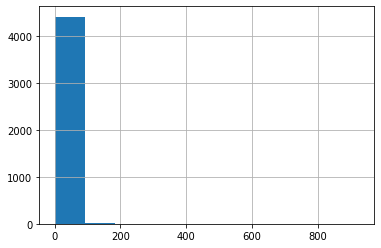

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count